In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import h5py
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from astropy.cosmology import FlatLambdaCDM
import pickle
import lzma
from shark import SharkSnap

In [47]:
data_dir = "/mnt/home/drennehan/ceph/simulating_the_universe/overdensity_intersections/sims/shark/1024_200/STU/default"
redshifts_file = "/mnt/home/drennehan/ceph/simulating_the_universe/overdensity_intersections/sims/dhalos/output_redshifts_fixed.txt"
save_file = "./data/SharkSnap_065.pkl"
overwrite_save = True
nsubvols = 8

redshift_map = np.loadtxt(redshifts_file)
snap_list = [118, 105, 95, 85, 75, 65, 55, 45, 35, 25, 15, 5, 0]
redshifts = redshift_map[snap_list][:, 1]
redshifts

array([ 0.      ,  0.549296,  1.68293 ,  5.08176 ,  5.52643 ,  6.04124 ,
        6.64424 ,  7.36018 ,  8.22409 ,  9.28713 , 10.6271  , 12.3684  ,
       13.4505  ])

# Galaxy distributions

I want an initial look at the galaxy distributions generated by the Shark semi-analytic model. The SharkSnap class will allow me to access the HDF5 data directly as a Pandas DataFrame.

In [48]:
if not os.path.isfile(save_file) or overwrite_save:
    z2 = SharkSnap(data_dir, 95, nsubvols)
else:
    z2 = pickle.load(lzma.open(save_file, "rb"))

Found 738736 galaxies in L = 200 cMpc/h


## Overdensities

I want to compare variables from the multidimensional joint probability distributions of the galaxy population to their environment indicators, such as the local galaxy overdensity $\delta(<R) = (n_\mathrm{gal} - \overline{n}_\mathrm{gal}) / \overline{n}_\mathrm{gal}$. The idea is to compute the number of galaxies $N_\mathrm{gal}$ within a sphere of radius $R$ and compute the mean number density in that sphere $n_\mathrm{gal} = 3 / (4\pi R^3)$ and compare that to the mean number density of galaxies in the entire volume, $\overline{n}_\mathrm{gal} = N_\mathrm{gal,total} / L^3$, where $L$ is the side-length of the simulation volume. First, I want a random sample of $M$ spheres with radius $R$ that act like a control sample, giving an overview of the underlying overdensity distribution of all space.

In [49]:
# radius of the sample sphere, should be the same for all samples during a comparison
filter_radius = 10. / z2.h

In [50]:
random_delta = z2.compute_galaxy_overdensities(filter_radius=filter_radius, random=10000)

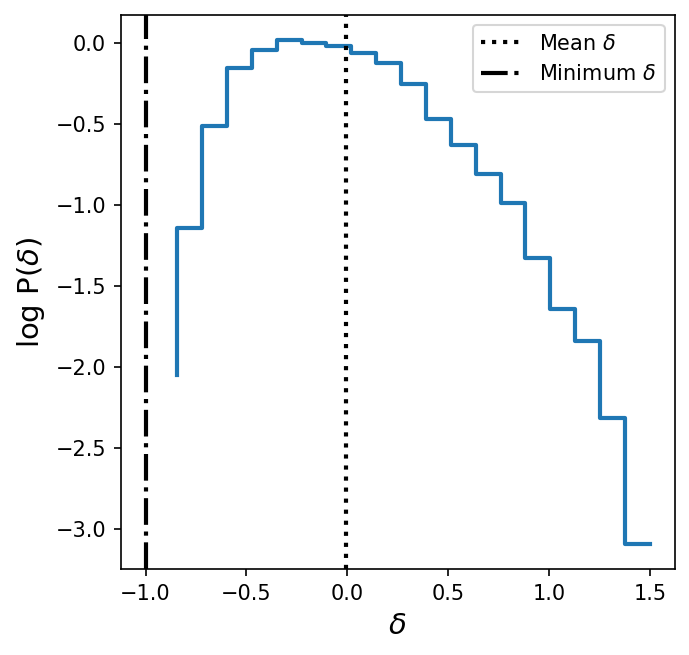

In [51]:
hist, be = np.histogram(random_delta, bins=20, density=True)
plt.figure(figsize=z2.figsize, dpi=z2.dpi)
plt.ylabel("log P($\delta$)", fontsize=z2.axes_fontsize)
plt.xlabel("$\delta$", fontsize=z2.axes_fontsize)
plt.step((be[1:] + be[:-1])/2, np.log10(hist), lw=2)
plt.axvline(np.mean(random_delta), ls=":", lw=2, c="k", label="Mean $\delta$")
rho_min = 1. / (4. * np.pi / 3. * (10. / z2.h)**3)
rho_mean = z2.ngal / z2.lbox**3
delta_min = (rho_min - rho_mean) / rho_mean
plt.axvline(delta_min, ls="-.", c="k", lw=2, label="Minimum $\delta$")
ax = plt.gca()
ax.set_aspect(np.diff(ax.get_xlim())/np.diff(ax.get_ylim()))
plt.legend()
plt.show()
plt.close()

### Galaxy centered overdensities

I compute the overdensity distribution centered on each galaxy in the snapshot. The compute_galaxy_overdensities function stores the overdensities at each galaxy in the DataFrame as a new column.

In [52]:
z2.compute_galaxy_overdensities(filter_radius=filter_radius)

/tmp/ipykernel_2734669/349808800.py:8: RuntimeWarning: divide by zero encountered in log10
  plt.step(be[:-1], np.log10(hist_random), lw=2, label="Random")
/tmp/ipykernel_2734669/349808800.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.step(be[:-1], np.log10(hist_centered), lw=2, label="Galaxy-centric")


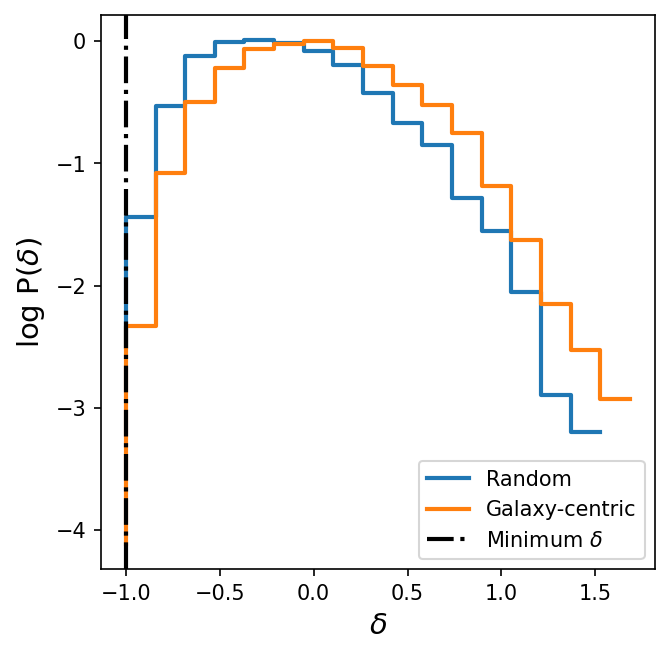

In [53]:
be = np.linspace(-1, 2, 20)
hist_random, _ = np.histogram(random_delta, bins=be, density=True)
hist_centered, _ = np.histogram(z2.df["filter_delta_14"], bins=be, density=True)

plt.figure(figsize=z2.figsize, dpi=z2.dpi)
plt.ylabel("log P($\delta$)", fontsize=z2.axes_fontsize)
plt.xlabel("$\delta$", fontsize=z2.axes_fontsize)
plt.step(be[:-1], np.log10(hist_random), lw=2, label="Random")
plt.step(be[:-1], np.log10(hist_centered), lw=2, label="Galaxy-centric")
rho_min = 1. / (4. * np.pi / 3. * (10. / z2.h)**3)
rho_mean = z2.ngal / z2.lbox**3
delta_min = (rho_min - rho_mean) / rho_mean
plt.axvline(delta_min, ls="-.", c="k", lw=2, label="Minimum $\delta$")
ax = plt.gca()
ax.set_aspect(np.diff(ax.get_xlim())/np.diff(ax.get_ylim()))
plt.legend()
plt.show()
plt.close()

From the above comparison plot, galaxies are biased towards regions of space with other galaxies -- they are clustered.

### Joint distributions

The SharkSnap class has a built in simple plotting function that allows me to compare 2D joint distributions of galaxy properties from the DataFrame. In this case, I want to use the filter on the same scale since I haven't produced any other overdensity information.

In [54]:
filter_key = "filter_delta_14"

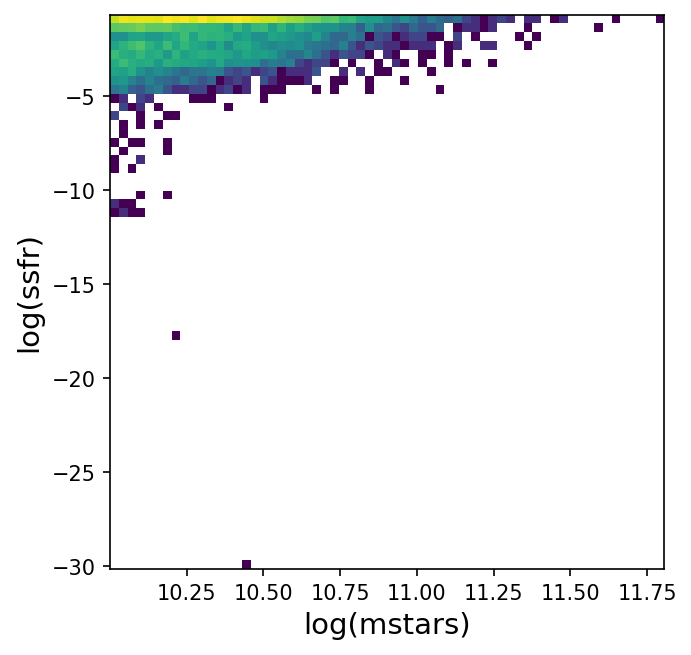

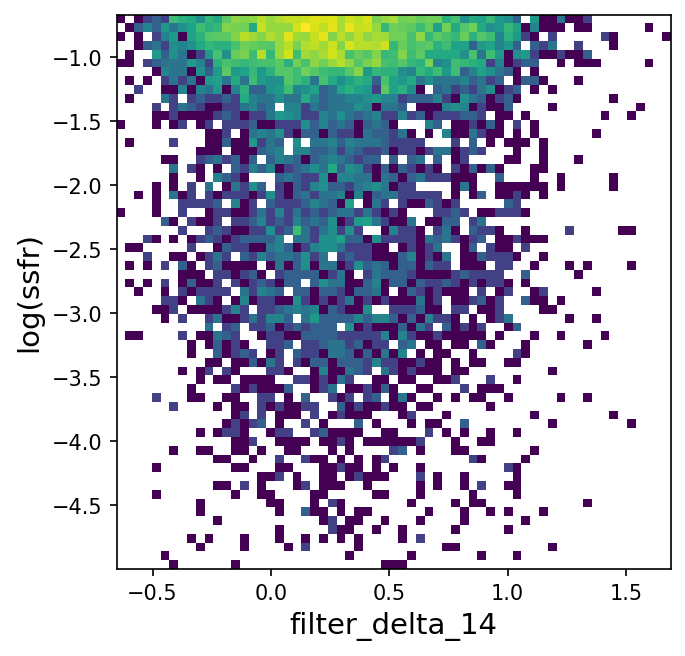

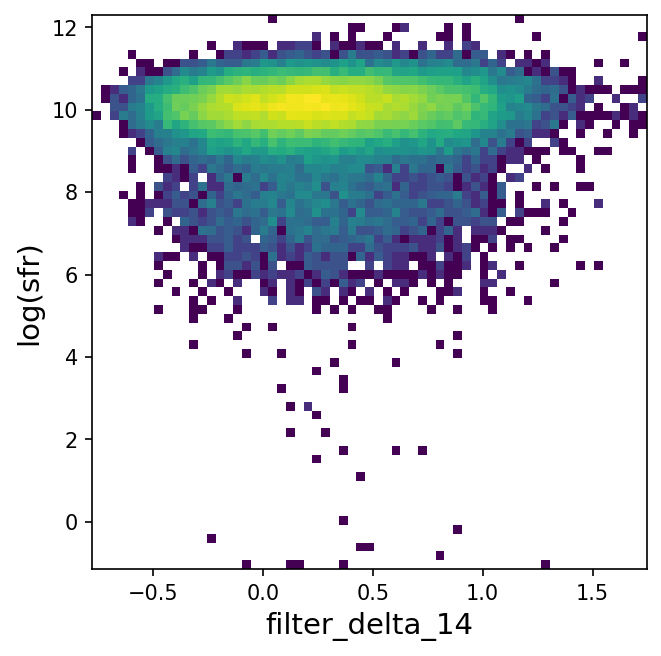

In [55]:
massive_galaxy_limit = 1e10 # Msun

# This is by definition, it could really be any threshold
ssfr_limit = 0.2 / z2.cosmo.age(redshifts[5]).to("Gyr").value

z2.plot_histogram2d("mstars", "ssfr", 
                    transform=["log", "log"], 
                    mask=((z2.df["type"] == 0) & (z2.df["mstars"] > massive_galaxy_limit) & (z2.df["ssfr"] < ssfr_limit)))
z2.plot_histogram2d(filter_key, "ssfr", 
                    transform=[None, "log"], 
                    mask=((z2.df["type"] == 0) & (z2.df["mstars"] > massive_galaxy_limit) & (z2.df["ssfr"] < ssfr_limit) & (z2.df["ssfr"] > 10**-5)))
z2.plot_histogram2d(filter_key, "sfr", 
                    transform=[None, "log"], 
                    mask=((z2.df["type"] == 0) & (z2.df["mstars"] > massive_galaxy_limit) & (z2.df["sfr"] > 1e-3)))

## Pickle the data

The filtered overdensities and DataFrame can be saved to a pickle file for further analysis.

In [56]:
if overwrite_save:
    with lzma.open(save_file, "wb") as f:
        pickle.dump(z2, f, protocol=pickle.HIGHEST_PROTOCOL)